# Pretrain on unlabeled data

In [1]:
import torch

from gpt2 import load_model, complete_text, text_to_tensor

start_context = "Hello, my name is"
model = load_model()
print(complete_text(start_context, model,10))

Hello, my name is hauled manyrikesdeconder ZionJS partingachusetts Civic


### Generate Text without training

In [2]:
from gpt2 import dataloader_v1

with open("world_war_ii.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
dataloader = dataloader_v1(raw_text,batch_size=2, context_size=4,stride=1)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("shape of input: ",inputs.shape)
print("first batch, input: \n", inputs,"\n targets: \n", targets)

shape of input:  torch.Size([2, 4])
first batch, input: 
 tensor([[10603,  1810,   314,   393],
        [ 1810,   314,   393,   262]]) 
 targets: 
 tensor([[1810,  314,  393,  262],
        [ 314,  393,  262, 3274]])


In [3]:
from gpt2 import tensor_to_text,build_tokenizer
tokenizer = build_tokenizer()
for i in range(inputs.size(0)):
    text = tensor_to_text(inputs[i].unsqueeze(0), tokenizer)
    print(f"Input {i}: {text}")

for i in range(targets.size(0)):
    text = tensor_to_text(targets[i].unsqueeze(0), tokenizer)
    print(f"target {i}: {text}")

Input 0: World War I or
Input 1:  War I or the
target 0:  War I or the
target 1:  I or the First


In [4]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print("shape of logits: ",logits.shape)
print("shape of probas: ",probas.shape)

shape of logits:  torch.Size([2, 4, 50257])
shape of probas:  torch.Size([2, 4, 50257])


In [5]:
output_token_ids = torch.argmax(probas, dim=-1) # Replace probas with logits yield same result
print("shape of output_token_ids: ",output_token_ids.shape)
print("output_token_ids: \n",output_token_ids)

for i in range(output_token_ids.size(0)):
    text = tensor_to_text(output_token_ids[i].unsqueeze(0), tokenizer)
    print(f"output {i}: {text}")

shape of output_token_ids:  torch.Size([2, 4])
output_token_ids: 
 tensor([[38491,  2448, 36069, 24862],
        [36397, 15489, 10460, 18747]])
output 0:  constants Per Rebels myriad
output 1:  Gathering bay 800array


### Loss: Cross-Entropy and Perplexity

In [6]:
print("shape of probas: ",probas.shape)
print("shape of targets: ",targets.shape)
print(targets)


shape of probas:  torch.Size([2, 4, 50257])
shape of targets:  torch.Size([2, 4])
tensor([[1810,  314,  393,  262],
        [ 314,  393,  262, 3274]])


In [7]:
batch_size, seq_len = targets.shape
target_probas = torch.empty(batch_size, seq_len)

for text_idx in range(batch_size):
    positions = torch.arange(seq_len)
    #same as probas[0,[0,1,2,3],[2402,  257,  640,  612]], advanced indexing
    target_probas[text_idx] = probas[text_idx, positions, targets[text_idx]]
    #Note that even for the same token ID, the predicted probabilities can vary across positions or sequences because the model's output depends heavily on the surrounding context.
    print(f"Text {text_idx + 1} target_probas:", target_probas[text_idx])


Text 1 target_probas: tensor([9.9453e-06, 1.9406e-05, 1.4083e-05, 1.9301e-05])
Text 2 target_probas: tensor([1.6926e-05, 2.1976e-05, 1.0548e-05, 1.9390e-05])


#### Cross Entropy Loss

For a single classification sample, assume:

- True label (one-hot):
  $$\mathbf{y} = (y_1, y_2, \dots, y_C), \quad y_i \in \{0, 1\}$$

- Predicted probabilities:
  $$\hat{\mathbf{y}} = (\hat{y}_1, \hat{y}_2, \dots, \hat{y}_C), \quad \sum_{i=1}^C \hat{y}_i = 1$$

---

#### Cross Entropy Loss (General Form)

$$
\mathcal{L}(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{i=1}^C y_i \log(\hat{y}_i)
$$

If the true class is \(k\), the formula simplifies to:

$$
\mathcal{L} = - \log(\hat{y}_k)
$$

---

#### Cross Entropy Over a Batch of \(N\) Samples

$$
\mathcal{L}_{\text{batch}} = - \frac{1}{N} \sum_{n=1}^N \sum_{i=1}^C y_i^{(n)} \log \left( \hat{y}_i^{(n)} \right)
$$


In [8]:
neg_log_probas = torch.log(target_probas) * -1
print("neg_log_probas: ",neg_log_probas)
loss = torch.mean(neg_log_probas)
print("loss: ",loss)

neg_log_probas:  tensor([[11.5184, 10.8499, 11.1706, 10.8554],
        [10.9867, 10.7256, 11.4596, 10.8508]])
loss:  tensor(11.0521)


In [9]:
print("shape of inputs: ",logits.shape) #(batch_size, seq_len, vocab_size)
print("shape of targets: ",targets.shape)
print("targets: \n",targets) #(batch_size, seq_len)
# inputs must be raw logits (unnormalized scores), NOT probabilities
# inputs shape: (batch_size * seq_len, vocab_size)
# targets shape: (batch_size * seq_len,), containing class indices
loss = torch.nn.functional.cross_entropy(logits.view(-1,logits.size(-1)), targets.view(-1))
print("loss: ",loss)

shape of inputs:  torch.Size([2, 4, 50257])
shape of targets:  torch.Size([2, 4])
targets: 
 tensor([[1810,  314,  393,  262],
        [ 314,  393,  262, 3274]])
loss:  tensor(11.0521)


#### Perplexity and Cross Entropy Loss

Given the average cross entropy loss \(\mathcal{L}\) defined as:

$$
\mathcal{L} = - \frac{1}{N} \sum_{i=1}^N \log P(w_i)
$$

The **perplexity** is computed by exponentiating the loss:

$$
\mathrm{Perplexity} = e^{\mathcal{L}}
$$

Perplexity can indeed be larger than the vocabulary size, though usually it’s not.


In [10]:
perplexity = torch.exp(loss)
#Note perplexity is larger than vocab_size, which is expected, since the model is not trained yet.
print("perplexity: ",perplexity)

perplexity:  tensor(63076.7070)


### Losses on the training and validation sets


In [11]:
# If you didn't clean the empty lines, LLM may learn to add too many blanks.
def clean_text_remove_empty_lines(text: str) -> str:
    lines = text.splitlines()
    non_empty_lines = [line.strip() for line in lines if line.strip() != ""]
    return "\n".join(non_empty_lines)

with open("world_war_ii.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
cleaned_text = clean_text_remove_empty_lines(raw_text)

print(cleaned_text[:200])
tokens = tokenizer.encode(cleaned_text)
print("Characters: ",len(cleaned_text))
print("Tokens: ",len(tokens))

World War I or the First World War (28 July 1914 – 11 November 1918), also known as the Great War, was a global conflict between two coalitions: the Allies (or Entente) and the Central Powers. Fightin
Characters:  88775
Tokens:  18134


In [12]:
from gpt2 import GPT_CONFIG_124M

# Split text data into training and validation sets
train_ratio = 0.8
split_idx = int(len(cleaned_text) * train_ratio)
train_data, val_data = cleaned_text[:split_idx], cleaned_text[split_idx:]
print("Train data: ", len(train_data))
print("Val data: ", len(val_data))

torch.manual_seed(123)
train_loader = dataloader_v1(
    train_data, batch_size=2,
    context_size=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True, shuffle=True)
val_loader = dataloader_v1(
    val_data, batch_size=2,
    context_size=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False, shuffle=False)


Train data:  71020
Val data:  17755


In [13]:
print("Train dataloader: ", len(train_loader))
train_first_batch = next(iter(train_loader))
print(train_first_batch[0].shape, train_first_batch[1].shape)
print("Val dataloader: ", len(val_loader))
val_first_batch = next(iter(val_loader))
print(val_first_batch[0].shape, val_first_batch[1].shape)


Train dataloader:  7
torch.Size([2, 1024]) torch.Size([2, 1024])
Val dataloader:  2
torch.Size([2, 1024]) torch.Size([2, 1024])


In [14]:
def loss_batch(inputs, targets, model, device):
    inputs, targets = inputs.to(device), targets.to(device)
    logits = model(inputs)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), targets.flatten(0))
    return loss


def loss_loader(loader, model, device, num_batches=None):
    if len(loader) == 0:
        return float('nan')

    total_loss = 0.0
    # num_batches no more than len(loader), default to len(loader)
    num_batches = min(num_batches or len(loader), len(loader))

    for i, (inputs, targets) in enumerate(loader):
        if i >= num_batches:
            break
        loss = loss_batch(inputs, targets, model, device)
        total_loss += loss.item()

    return total_loss / num_batches

In [15]:
# MPS may have some issues when training, using cpu for play
# device = (
#     torch.device("cuda") if torch.cuda.is_available()
#     else torch.device("mps") if torch.backends.mps.is_available()
#     else torch.device("cpu")
# )
device = torch.device("cpu")

model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    train_loss = loss_loader(train_loader, model, device)
    val_loss = loss_loader(val_loader, model, device)
print("Train loss: ", train_loss)
print("Val loss: ", val_loss)

Train loss:  11.002508980887276
Val loss:  10.987592697143555


### Train

In [21]:

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, tokens_seen_track = [], [], []
    tokens_seen, step = 0, 0

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            tokens_seen += input_batch.numel()
            step += 1

            if step % eval_freq == 0:
                train_loss = loss_loader(train_loader, model, device, eval_iter)
                val_loss = loss_loader(val_loader, model, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                tokens_seen_track.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, tokens_seen_track


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    with torch.no_grad():
        result = complete_text(start_context, model,20)
        print(result)
    model.train()


In [19]:
from gpt2 import GPT2Model
import time

# Set seed for reproducibility
torch.manual_seed(123)
# Initialize model and optimizer
model = GPT2Model(GPT_CONFIG_124M).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.1)

# Start timer
start_time = time.time()

# Train the model
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="at the start of",
    tokenizer=tokenizer
)

# Report execution time
elapsed = (time.time() - start_time) / 60
print(f"Training completed in {elapsed:.2f} minutes.")


Ep 1 (Step 000005): Train loss 8.430, Val loss 8.680
at the start of the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 2 (Step 000010): Train loss 7.085, Val loss 7.874
at the start of the the, the, the, the, the, the, the, the, the, the, the, the, the, the the the the, the, the, the the the, the, the, the, the, the,
Ep 3 (Step 000015): Train loss 6.544, Val loss 7.768
Ep 3 (Step 000020): Train loss 6.333, Val loss 7.867
at the start of the war, the war, and the war, the war, and the war, the war, the war, and the war, and the war, and the war, the war, the war, the war, the war, and the war
Ep 4 (Step 000025): Train loss 6.149, Val loss 7.955
at the start of the war, and French, and the war, and the war, and the war, and French, and the war, and the war, and the war, and French, and the war, and the war, which, and the war,
Ep 5 (Step

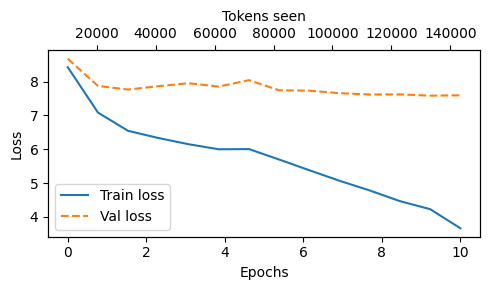

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs, tokens, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs, train_losses, label="Train loss")
    ax1.plot(epochs, val_losses, linestyle="--", label="Val loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    # plt.savefig("loss-plot.pdf")
    plt.show()

# Example usage
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


### Decoding Strategies to control randomness

In [292]:
model.to("cpu")
model.eval()
result = complete_text("at the start of", model,15)
print("Output text:\n", result)


Output text:
 at the start of the war, and Austria-Hungary and the German Army, and the


#### Sample decoding:
- Greedy decoding: Select the word with the highest probability (argmax) at each step.

- Sampling decoding: Randomly sample the next word from the probability distribution, for example using torch.multinomial.

In [293]:
import torch

input_text = "At the start of the"
input_tensor = text_to_tensor(input_text, tokenizer)
print("Input tensor: ", input_tensor)

logits = model(input_tensor)
print("Shape of logits: ", logits.shape)

next_token_logits = logits[:, -1, :]
print("Shape of next_token_logits: ", next_token_logits.shape)
print("next_token_logits: ", next_token_logits)

probas = torch.softmax(next_token_logits, dim=-1)
next_token_id = torch.argmax(probas, dim=-1).item()
print("Next token id: ", next_token_id)

next_token = tokenizer.decode(next_token_id)
print("Next token: ", next_token)

Input tensor:  tensor([[2953,  262,  923,  286,  262]])
Shape of logits:  torch.Size([1, 5, 50257])
Shape of next_token_logits:  torch.Size([1, 50257])
next_token_logits:  tensor([[-0.4246,  1.7134, -3.7874,  ..., -3.7822, -3.4160, -3.2244]],
       grad_fn=<SliceBackward0>)
Next token id:  1175
Next token:   war


In [295]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print("Next token id: ", next_token_id)
next_token = tokenizer.decode(next_token_id)
print("Next token: ", next_token)

Next token id:  34158
Next token:   Ottoman


In [296]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(100)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=probas.shape[-1])
    for id, freq in enumerate(sampled_ids):
        if freq > 1:
            print(f"{freq} x {tokenizer.decode(id)}")

print_sampled_tokens(probas)


2 x  V
2 x  first
2 x  two
3 x  war
2 x  Aust
2 x  First
2 x  League
4 x  French
2 x  Pacific
2 x  Som
2 x  Germans
2 x  Triple
4 x  Allies
3 x  Ottoman
2 x  Petro


In [351]:
import torch

#Complete 'At the start of the'
possible_text = "war battle revolution novel experiment day journey movement"
words = possible_text.lower().split()
vocab = {word: idx for idx, word in enumerate(words)}
inverse_vocab = {idx: word for word, idx in vocab.items()}

# Step 2: Generate random logits for each vocab token
vocab_size = len(vocab)
torch.manual_seed(123)
next_token_logits = torch.normal(mean=0.0, std=4.0, size=(vocab_size,))  # increase std to increase randomness

# Convert logits to probabilities
probas = torch.softmax(next_token_logits, dim=0)

# Pick next token by argmax
next_token_id = torch.argmax(probas).item()

# Decode and print the predicted token
print(f"Next generated token: {inverse_vocab[next_token_id]}")


Next generated token: day


In [353]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(100)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=probas.shape[-1])
    for id, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[id]}")

print_sampled_tokens(probas)


11 x war
31 x battle
7 x revolution
4 x novel
0 x experiment
46 x day
1 x journey
0 x movement


#### Temperature

In [354]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=-1)

# Temperature values
temperatures = [1.0, 0.3, 5]

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

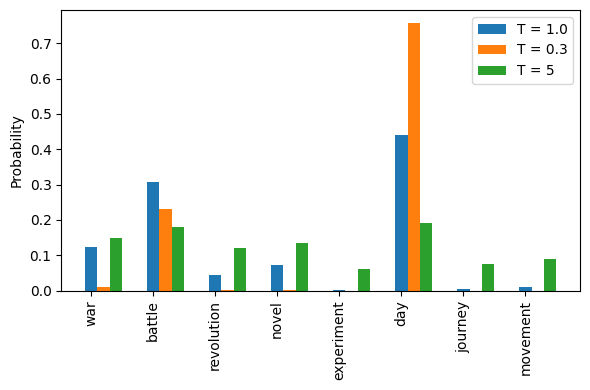

In [356]:
import torch
import matplotlib.pyplot as plt

# Plotting
x = torch.arange(len(vocab))
bar_width = 0.2

fig, ax = plt.subplots(figsize=(6, 4))

for i, T in enumerate(temperatures):
    ax.bar(x + i * bar_width, scaled_probas[i], width=bar_width, label=f"T = {T}")

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.show()


#### top-k Sampling